## Семинар 2

## `sklearn` и линейная регрессия

Topics:
* Основы Scikit-learn (cм. `ml_base.ipynb`)
* Overfitting или Переобучение; Underfitting или недообучение
* Что такое линейная регрессия и как не допустить переобучения в линейных моделях;
* Рассмотрим как обучается линейная реграссия и ее модификации: Lasso-(с L_1 регуляризацией) и Ridge-регрессию (с L_2 регуляризацией) для предсказания цены дома; 
* Поймем, в чем отличие между разными регуляризаторами;
* Научимся работать с разными типами признаков;
* Научимся пользоваться основными инструментами в `sklearn`: моделями, трансформерами и pipeline;
* Обсудим преобразования признаков и целевой переменной, которые могут помочь в обучении линейных моделей.

# Part 1

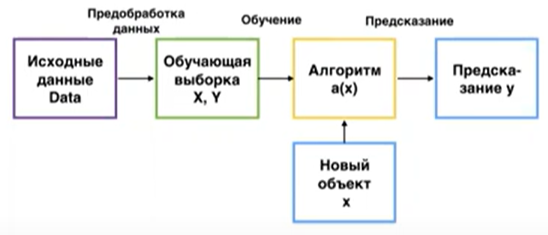

Из исходной базы данных после предобработки мы получаем обучающую выборку $X, Y$. Матрица объекты-признаки $X$ имеет размер (число объектов $\ell$) $\times$ (число признаков $d$). Одна строка этой матрицы соответствует одному объекту обучающей выборки, заданному как вектор длины $d$ (число признаков). Признаки - числовые характеристики объекта. Вектор правильных ответов $Y$ имеет длину $\ell$ (число объектов). 

На этапе обучения на основе обучающей выборки $X, Y$ строится (обучается) алгоритм $a(x)$. Это некая функция, которая берет на вход признаки объекта и возвращает предсказание для этого объекта: $y \approx a(x)$. Алгоритм $a$ может делать предсказания для любых допустимых объектов; его можно применять как к обучающим объектам, так и к тем, которых алгоритм никогда не видел. В этом и состоит цель машинного обучения: выявить такие закономерности в обучающей выборке, которые позволят делать качественные (довольно точные) предсказания на новых объектах $x$. 

Тому, как обучать такие алгоритмы $a(x)$ по обучающей выборке, во многом и посвящен наш курс.

Scikit-Learn, или коротко Sklearn - библиотека, в которой реализованы практически все используемые сегодня **алгоритмы машинного обучения**, а также **функции обработки (подготовки) данных** (стандартизация, нормализация, различные другие преобразования), а также **методы для работы с моделями** (кросс-валидация, подбор гиперпараметров, метрики оценки качества).

_Официальная документация:_ https://scikit-learn.org/stable/

**Установка через pip:** `pip install scikit-learn`

**Установка через conda:**`conda install -c conda-forge scikit-learn`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")

from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline

sns.set(style="darkgrid")

# Часть 0. Введение в линейные модели

Напомним, что линейная регрессия &mdash; это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию &mdash; значит найти $w$ и $w_0$.

В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не "вытащив" из данных никакой закономерности, от нее будет мало толку. Такую модель называют *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого нам понадобится сгенерировать синтетические данные. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ &mdash; целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечное количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\{x\}$, для второй &mdash; $\{x, x^2, x^3, x^4\}$, для третьей &mdash; $\{x, \dots, x^{20}\}$.

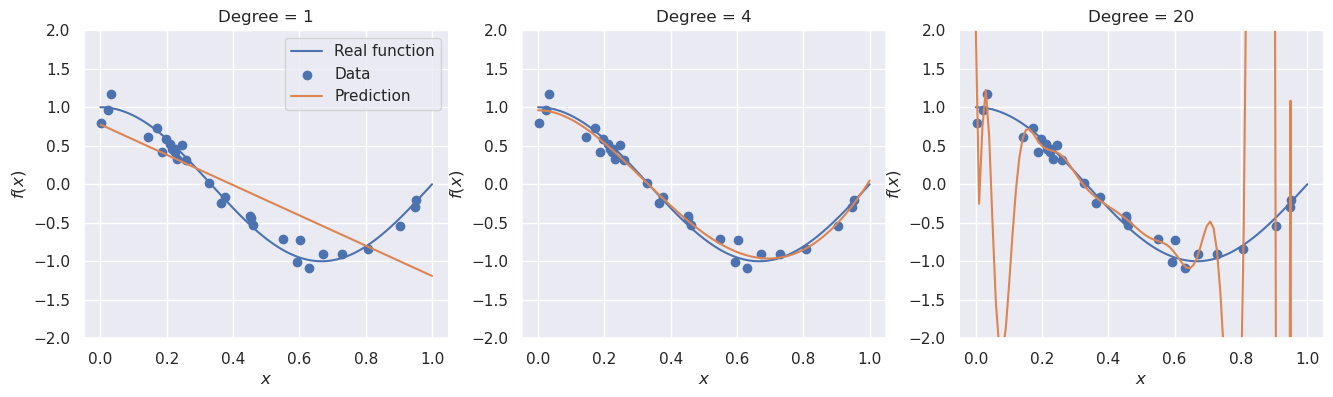

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(36)
x = np.linspace(0, 1, 100) # это неизвестные данные, на них мы будем делать предсказание и сравниваться с y
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30) # обучающая выборка, только чуть-чуть зашумленная
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree, include_bias=False).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

**Вопрос 1**: Почему первая модель получилась плохой, а третья переобучилась?

Данные всегда стоит нормализовать!

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связаны с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Функционал качества максимизируют, а функцию ошибки минимизируют. Если здесь переобучение в результате минимизации этого функционала, то веса получаются большими. И вместо того, чтобы стараться минимизировать только MSE на обучающей выборке, модель будет стараться минимизировать этот вес (квадратн нормы весов) и т.о. если правильно "затюнить" гиперпараметр $\lambda$, то мы можем избежать переобучения за счето того, что будем просо ограничивать большие значения весов. Они будут принимать меньшие значения и при помощи них учиться минимизировать MSE. И это будет лучше для обобщающей способности модели.  

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ &mdash; коэффициентом регуляризации. 

Есть еще  $\ell_1$-регуляризатор, по-другому LASSO. В этом случае в отличие от  $\ell_2$-регуляризатором, мы прибавляем сумму модулей весов. Есть особенность, которую увидим дальше: LASSO зануляет часть весов (линейно-зависимые или малозначимые). 



**Вопрос 2**: Почему большие веса в линейной модели &mdash; плохо?




Представим, что мы построили модель, чтобы предсказать цену квартиры. 
И у меня получилось, что-нибудь типа такого: 
$$a(x) = 10^8*площадь - 10^9*этаж + 10^9*[Петроградская] +\ldots $$

Допустим, мы обучили эту модель и получили большие веса. И даже если у этой модели хорошее качество на обучении, очевидно, что это плохая модель. Предстваим, что мы увеличиои площадь квартиры на 0.001 кубических метра. Тогда:
$$ 10^8*(площадь + 0.001) = 10^8*площадь + 10^8*0.001 $$

Т.е. выходит такая гиперчувствителность моделей к малейшим изменениям признаков. Это не соотвествует нашим представлении о природе. 

**Вопрос 3**: Почему регуляризовать $w_0$ &mdash; плохая идея?


$w_0$ &mdash; --- это просто intersept. Просто свободный член. У нас веса как-то смоделировали зависимость, intersept просто двигает наши предсказания вдоль оси ординат. Например, большой свободный коэффициент означает, что у вас признаки и целевая переменная немного невыровнены по масштабу. Поэтму важно не включать $w_0$ в резуляризацию. Иначе, если включить, то  вы запретите модели выравнивать масштаб целевой переменной и признаков. 

**Вопрос 4**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если $\lambda$ начать уменьшать? 

Мы будем концентрироваться на минимизации функионала ошибки в общем случае.

А в случае переобучения, будет возникать переобучение. 

**Вопрос 4.1**: Что будет, если $\lambda$ сделать слишком большим?

Если  $\lambda$  сделать слишком большим у нас скорее всего будут нулевые веса все, кроме свободного члена, потому что 2-ое слагаемое будет вносить больший вес. 

И наш intersept будет стараться будет приблизить целевую зависимость и будет проходить по прямой. И к тому же много важных признаков будет зануляться и наступит недообучение. 


# Часть 1. Загружаем данные

In [3]:
# !pip install wget
import wget 
wget.download('https://dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=1', 'train_sem2.csv')

'train_sem2.csv'

In [4]:
data = pd.read_csv("train_sem2.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Первое, что стоит заметить &mdash; у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестофвую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

**Вопрос 2**: Почему стоит дополнительно отделять валидационную выборку?

**Вопрос 3**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

In [11]:
from sklearn.model_selection import train_test_split

# data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

# X_train = 70 % 
# X_val = 20 %
# X_test/X_hold_out = 10 % 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [12]:
X_train[0:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
632,633,20,RL,85.0,11900,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Family
208,209,60,RL,NaN,14364,Pave,NaN,IR1,Low,AllPub,...,154,0,NaN,NaN,NaN,0,4,2007,WD,Normal


Посмотрим сначала на значения целевой переменной.

<Axes: xlabel='SalePrice', ylabel='Density'>

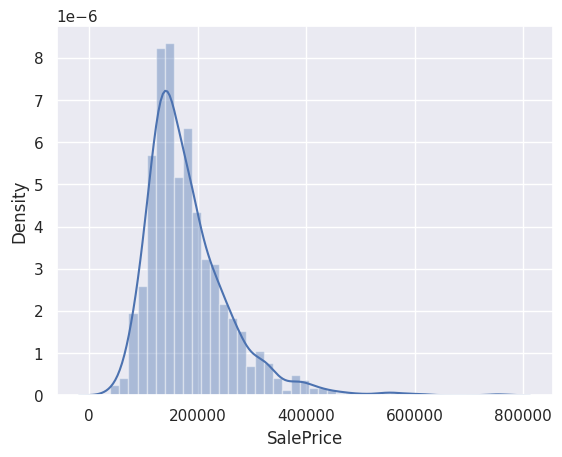

In [8]:
sns.distplot(y_train)

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Корреляция Пирсона записывается следующим образом:

$$
\text{corr}(X, Y)=\frac{\operatorname{cov}_{X Y}}{\sigma_X \sigma_Y}=\frac{\sum_{i=1}^n(X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n(X_i - \bar{X})^2 \sum_{i=1}^n(Y_i - \bar{Y})^2}}
$$

**Вопрос**: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен 1? -1? 0?

Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

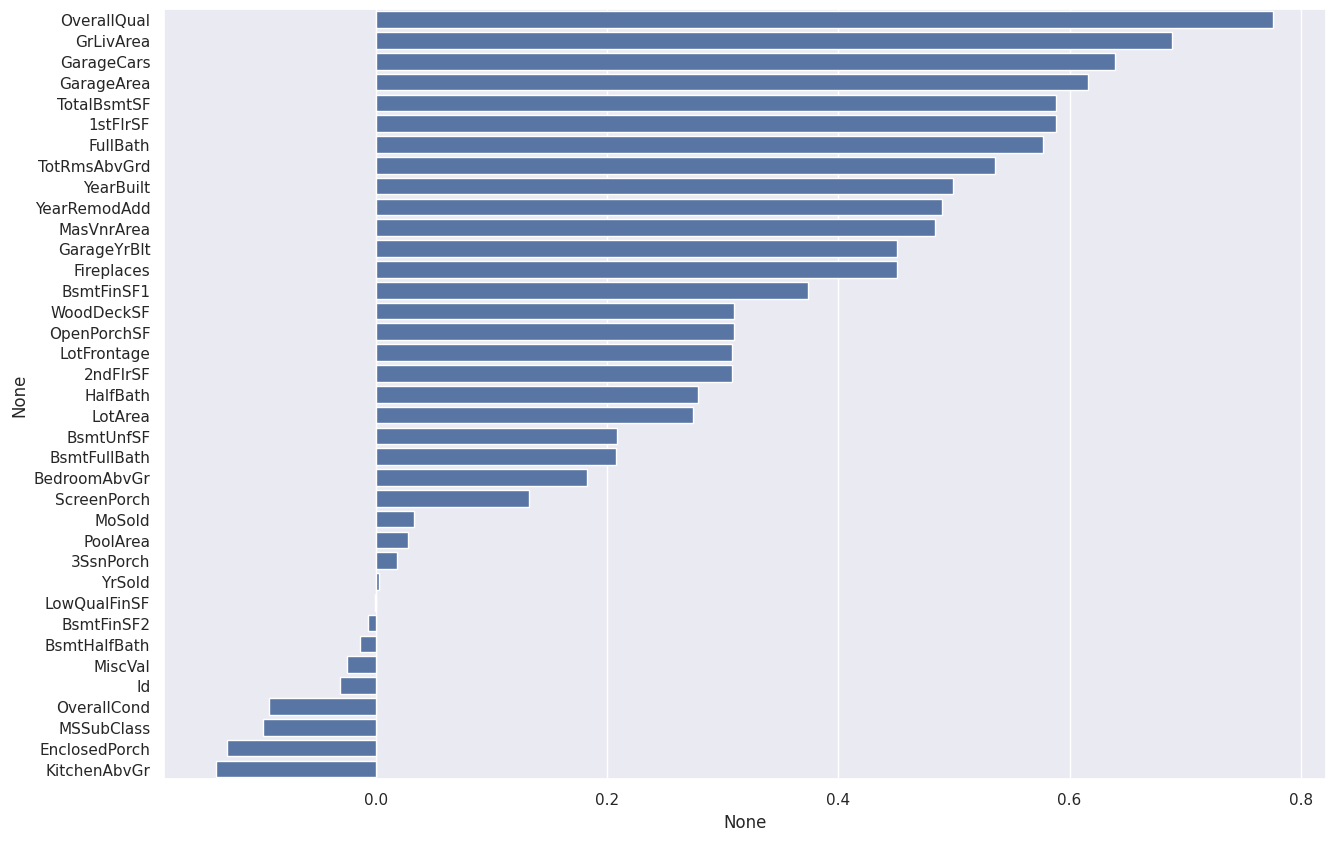

In [9]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).

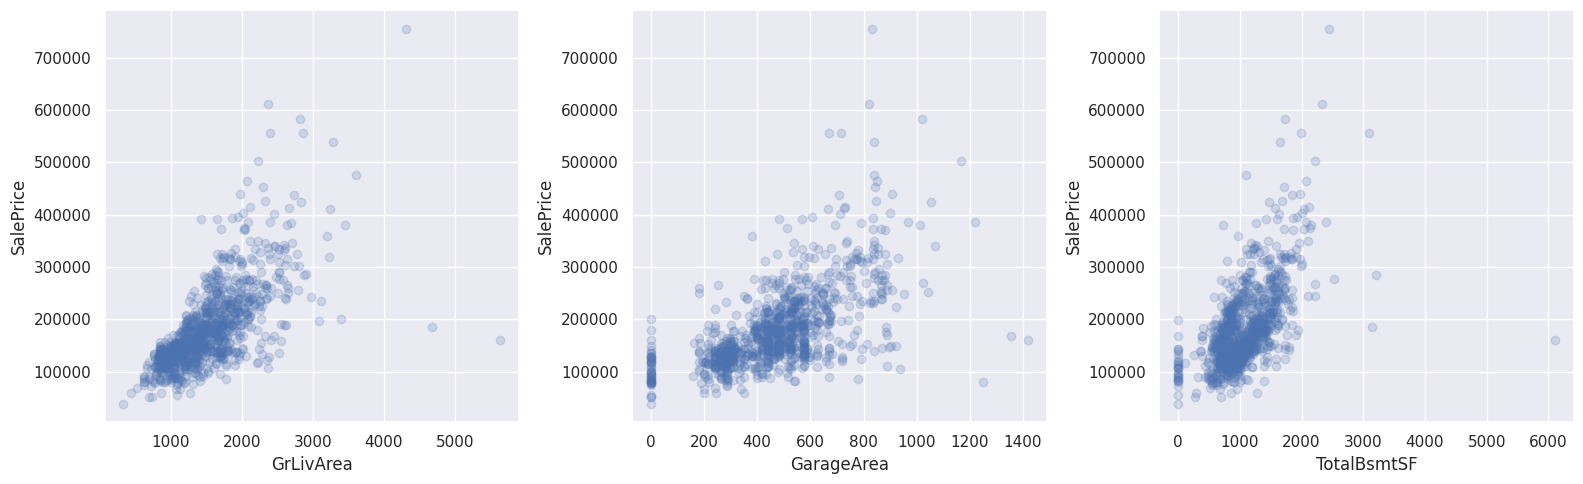

In [10]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.

# Часть 2. Модель

*Немного об обучении моделей*. В арсенале дата-саентиста кроме `pandas` и `matplotlib` должны быть библиотеки, позволяющие обучать модели. Для простых моделей (линейные модели, решающее дерево, ...) отлично подходит `sklearn`: в нем очень понятный и простой интерфейс. Несмотря на то, что в `sklearn` есть реализация бустинга и простых нейронных сетей, ими все же не пользуются и предпочитают специализированные библиотеки: `XGBoost`, `LightGBM` и пр. для градиентного бустинга над деревьями, `PyTorch`, `Tensorflow` и пр. для нейронных сетей. Так как мы будем обучать линейную регрессию, нам подойдет реализация из `sklearn`.

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$. Но в sklearn используется градиентный спуск по одной причине: из-за операции обращения, которая на самом деле кубически зависит от числа наблюдений.  
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [ ]:
X_train.shape

(1022, 80)

In [1]:
X_train[numeric_features]

NameError: name 'X_train' is not defined

In [ ]:
# !pip install scipy==1.7.3

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False)) 
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 34977.0038
Train RMSE = 35043.9627


In [ ]:
# np.set_printoptions(suppress=True)
model.coef_

array([-1.28771826e+00, -1.83718221e+02, -1.35685981e+02,  4.89663749e-01,
        1.73477141e+04,  5.04194983e+03,  3.08031257e+02,  1.54511357e+02,
        3.19226747e+01,  6.89551514e+00,  1.74139494e+00, -1.64151277e-01,
        8.47276186e+00,  8.58952827e+00,  6.63561189e+00,  1.07139897e+01,
        2.59391390e+01,  9.67936414e+03,  6.79159607e+03,  7.73463587e+03,
       -4.83105525e+02, -8.58004128e+03, -1.14791534e+04,  6.99889344e+03,
        5.32404340e+03,  1.85203944e+01,  1.30862400e+04, -2.22346161e+00,
        3.45528846e+01,  5.64936551e+00,  2.41842234e+01, -2.47868474e+00,
        7.23771405e+01, -1.16536867e+02, -3.13034572e-01, -3.30758037e+02,
       -1.30679701e+03])

Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

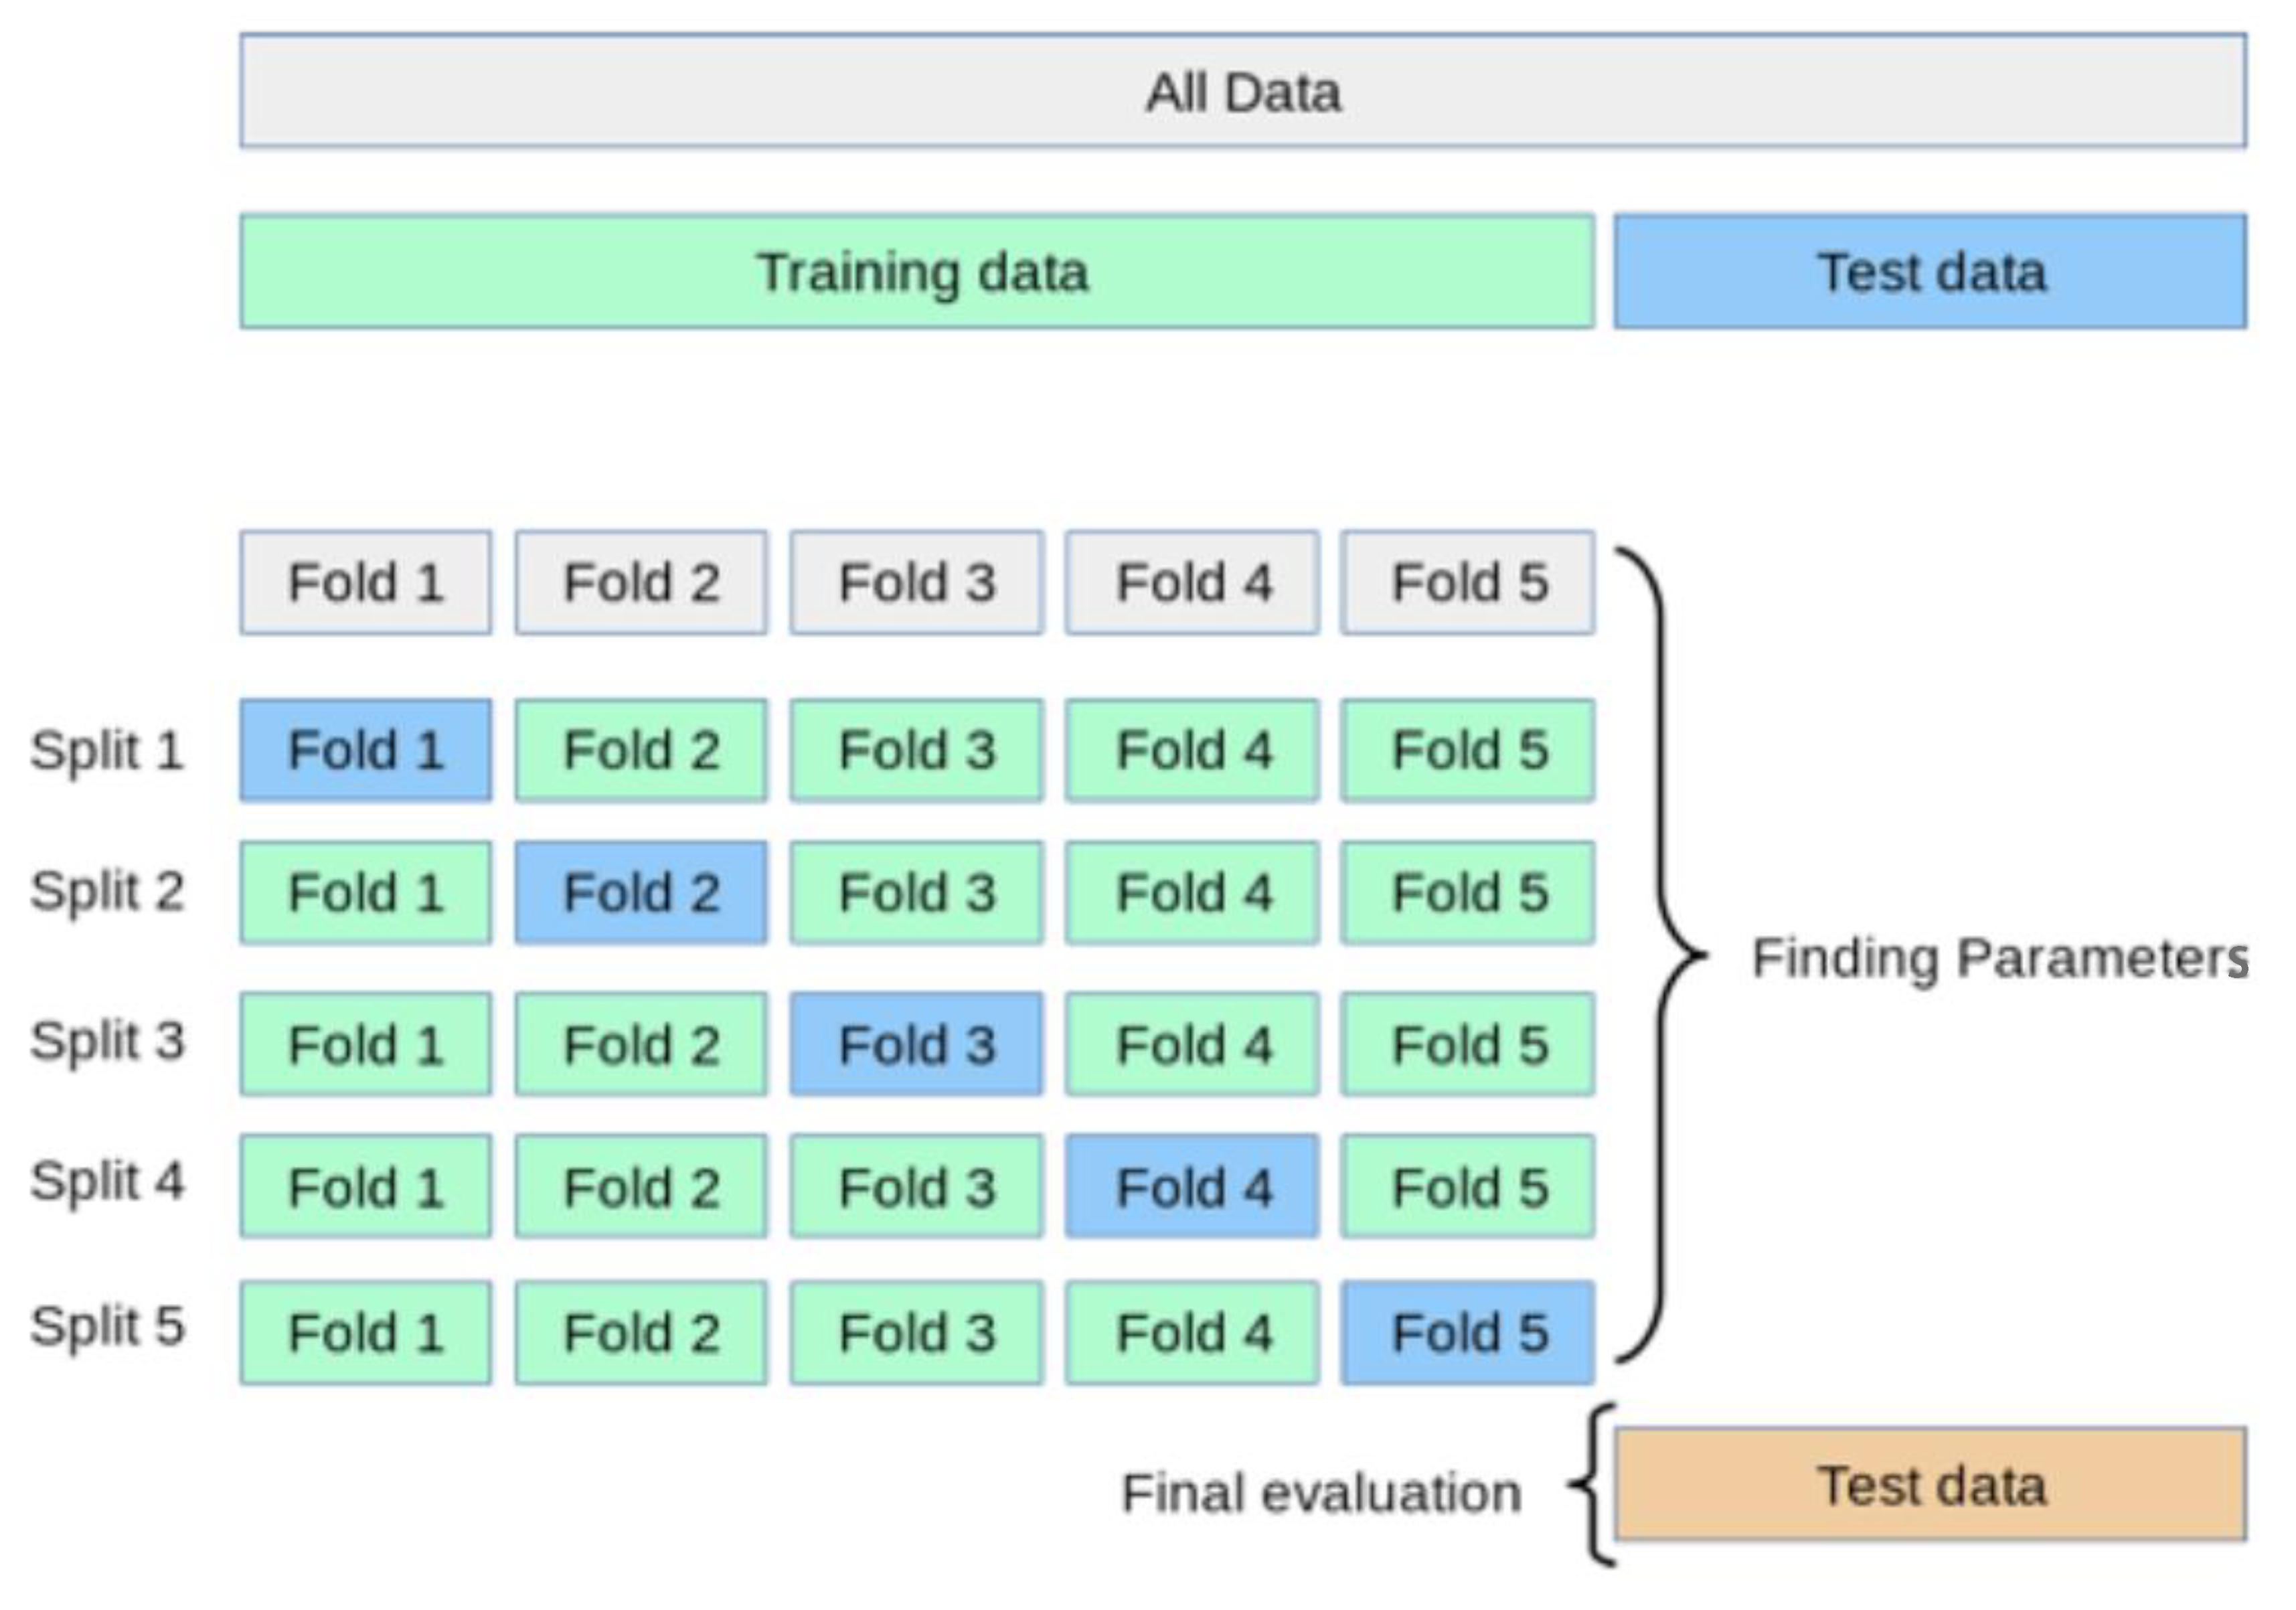

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

**Метод `cross_val_score` максимизирует метрику, так что вместо 
минимизации RMSE сделаем максимизацию отрицательного RMSE – `neg_mean_squared_error`.**

In [ ]:
y.mean()

180921.19589041095

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -66149.5790
	-34660.4431
	-38036.6833
	-34809.6053
	-54656.8301
	-43262.1710
	-33100.6084
	-29669.6476
	-25646.9173
	-31299.9400
Mean CV MSE = 39129.2425


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Обратите внимание, что по отложенной выборке и при кросс-валидации мы считаем RMSE (Root Mean Squared Error), хотя в функционале ошибки при обучении модели используется MSE.

$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

**Вопрос**: Почему оптимизация RMSE эквивалентна оптимизации MSE?

In [ ]:
# взятие корня это монотонное преобразование, оно не влияет на оптимизацию

Если бы RMSE не входил в стандартные метрики `sklearn`, можно было бы его определить через функцию `sklearn.metrics.make_scorer`.

In [ ]:
from sklearn.metrics import make_scorer


def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))


rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -66149.5790
	-34660.4431
	-38036.6833
	-34809.6053
	-54656.8301
	-43262.1710
	-33100.6084
	-29669.6476
	-25646.9173
	-31299.9400
Mean CV RMSE = 39129.2425


Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Вопрос**: Чему равна оптимальная константа для RMSE?

Среднее y_train. Т.к. если у нас есть целевая переменная и представим, что она есть одно и то же значение, от признаков мы никак не зависим. По сути мы доллжны минимиировать вот такой функционал ошибки $ \sqrt{\sum_{i}(y_i - c)^2}$. Возьмем производную, чтобы посмотореть в каком направлении наша функции имеет наибольший прирост или падение и приравняем к нулю (тюе. как мы ищем локальные мин/макс), то получим, что после взятия производной:
$ 2*\sqrt{\sum_{i}(y_i - c)} = 0$ 

In [ ]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % mean_squared_error(y_test, best_constant * np.ones(y_test.shape),
                                                                 squared=False))
print("Train RMSE with best constant = %.4f" % mean_squared_error(y_train, best_constant * np.ones(y_train.shape),
                                                                  squared=False))

Test RMSE with best constant = 84517.9069
Train RMSE with best constant = 77127.6608


Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес &mdash; тем более сильным является признак.
|


**Вопрос**: Почему это не совсем правда?

In [ ]:
def show_weights(features, weights, means, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=3)
    sorted_weights = sorted(zip(weights, features, means, scales), reverse=True)
    weights, features, means, scales = zip(*sorted_weights)
    features = list(features)
    
    sns.barplot(y=features, x=list(weights), ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=list(means), ax=axs[1])
    axs[1].set_xlabel("Mean")
    sns.barplot(y=features, x=list(scales), ax=axs[2])
    axs[2].set_xlabel("Scale")
    plt.tight_layout()

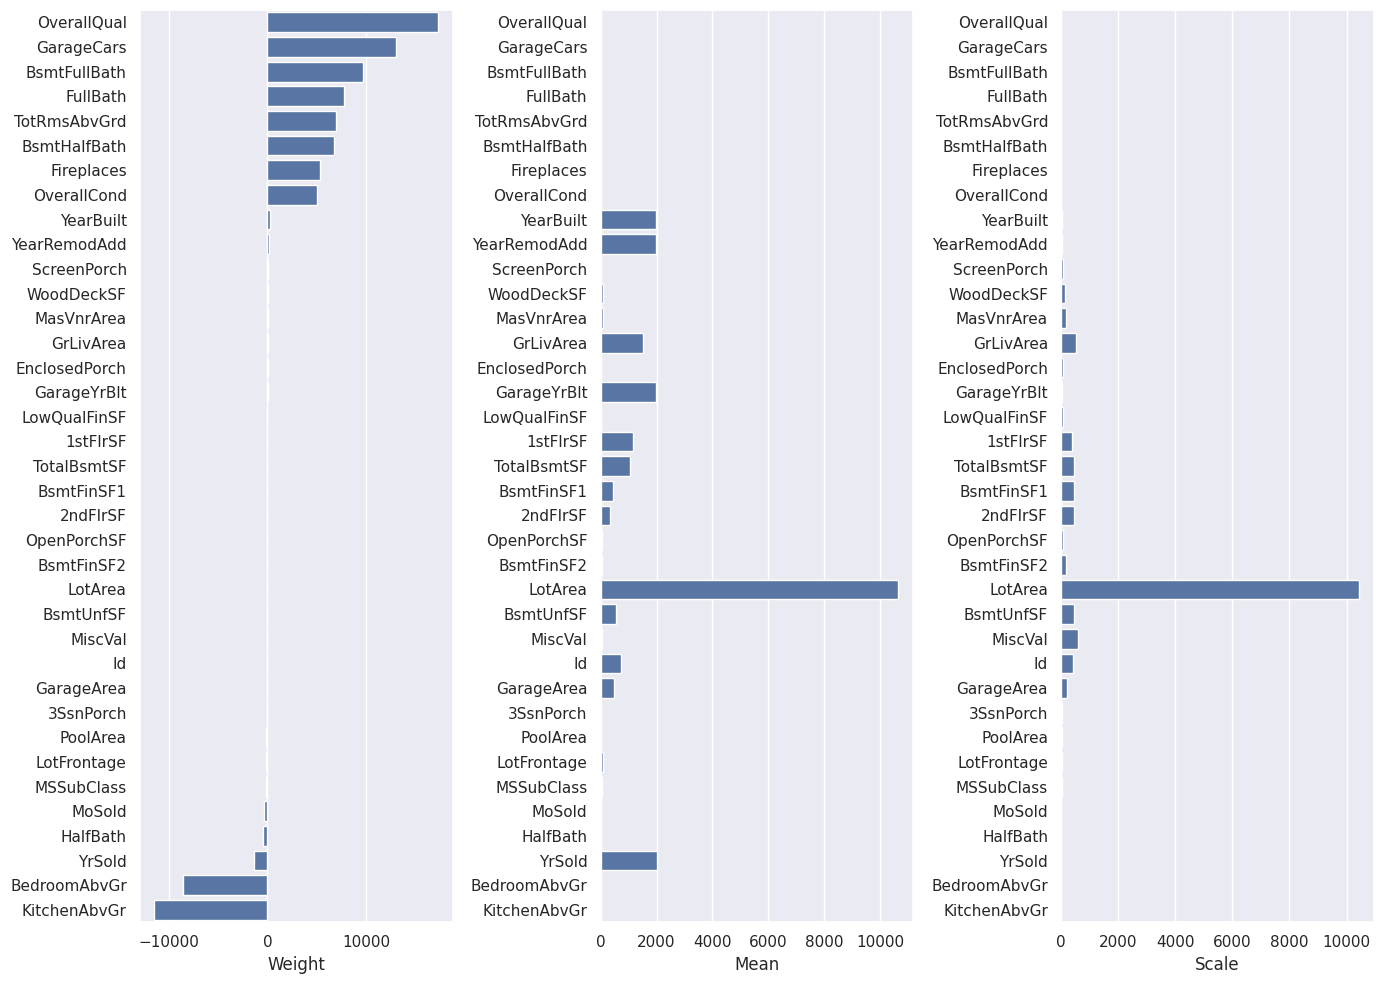

In [ ]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].mean(), X_train[numeric_features].std())

In [ ]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
X_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
X_train['OverallQual'].min()

1

In [ ]:
display(y.min())
y.max()

34900

755000

In [ ]:
X_train['OverallQual'].max()

10

In [ ]:
display(X_train['LotArea'].min())
X_train['LotArea'].max()

1300

215245

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени. 

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 34984.0608
Train RMSE = 35043.8567


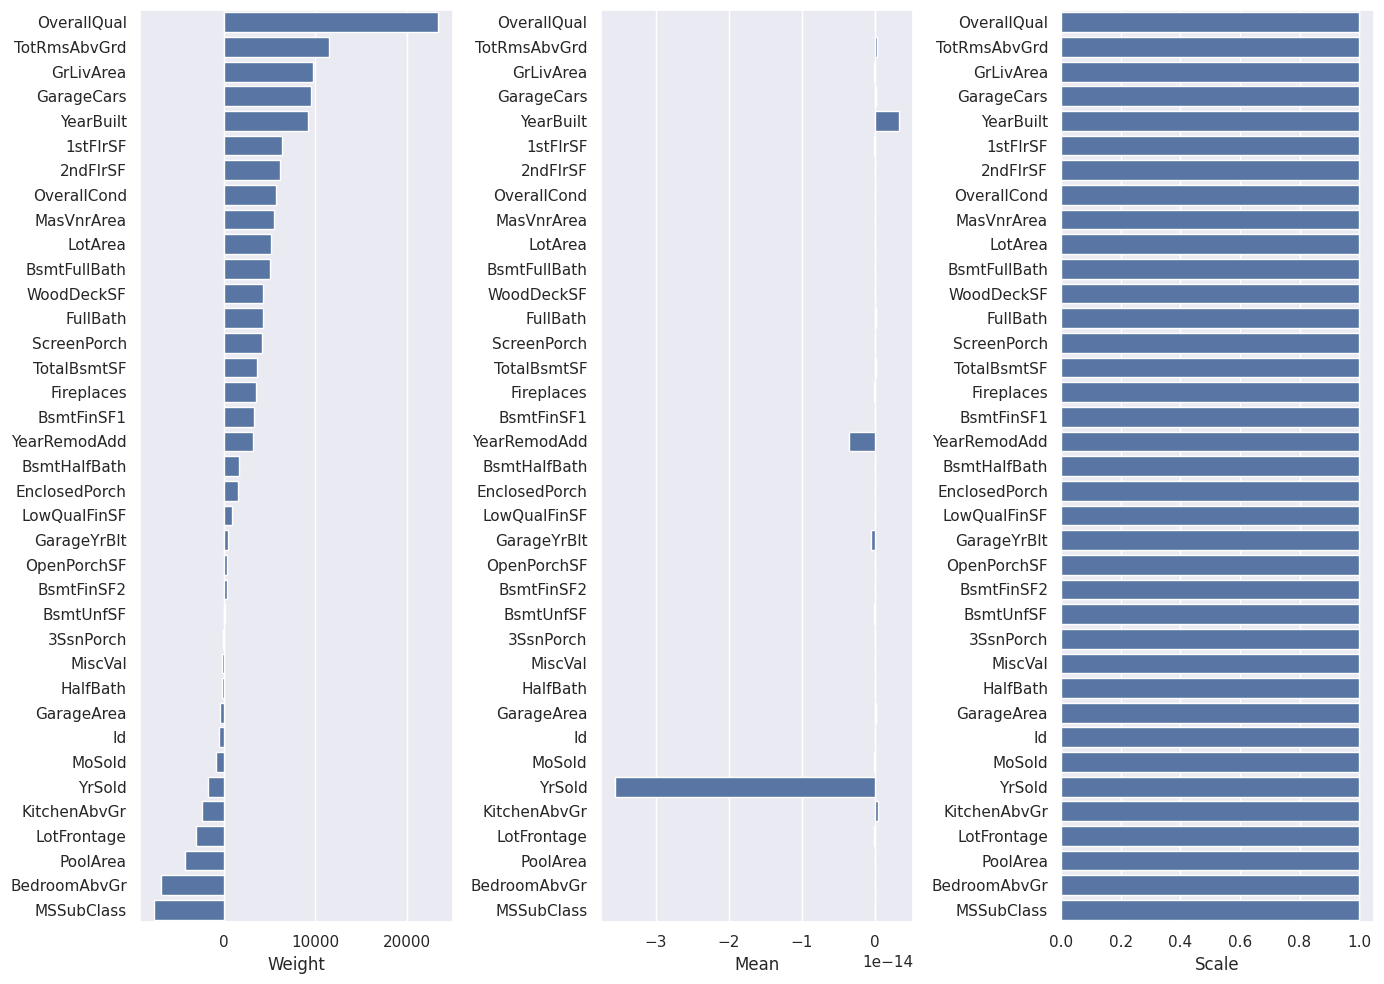

In [ ]:
means = pd.Series(data=X_train_scaled.mean(axis=0), index=numeric_features)
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, means, scales)

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это `alpha` &mdash; коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины).

In [ ]:

alphas = np.logspace(-2, 3, 20)
alphas

array([1.00000000e-02, 1.83298071e-02, 3.35981829e-02, 6.15848211e-02,
       1.12883789e-01, 2.06913808e-01, 3.79269019e-01, 6.95192796e-01,
       1.27427499e+00, 2.33572147e+00, 4.28133240e+00, 7.84759970e+00,
       1.43844989e+01, 2.63665090e+01, 4.83293024e+01, 8.85866790e+01,
       1.62377674e+02, 2.97635144e+02, 5.45559478e+02, 1.00000000e+03])

Best alpha = 297.6351


Text(0, 0.5, 'CV score')

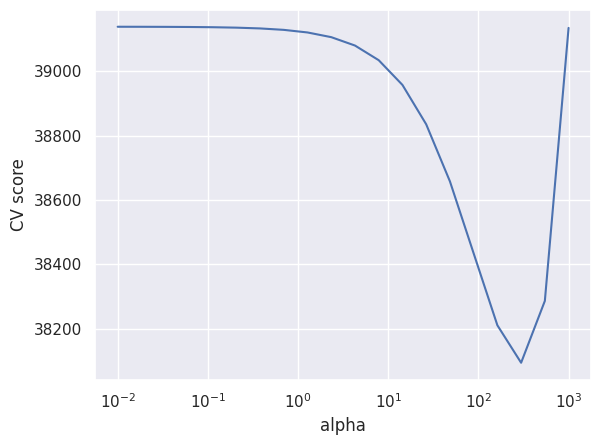

In [ ]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

**Вопрос**: Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой &mdash; `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой &mdash; `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [ ]:
X_train[numeric_features]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
632,633,20,85.000000,11900,7,5,1977,1977,209.0,822,...,544,192,0,0,0,0,0,0,4,2009
208,209,60,70.309353,14364,7,5,1988,1989,128.0,1065,...,454,60,55,0,0,154,0,0,4,2007
83,84,20,80.000000,8892,5,5,1960,1960,66.0,0,...,461,74,0,0,0,0,0,0,7,2007
1174,1175,70,80.000000,16560,6,8,1932,1950,0.0,503,...,360,0,0,0,0,0,0,0,7,2006
250,251,30,55.000000,5350,3,2,1940,1966,0.0,0,...,0,263,0,0,0,0,0,450,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,716,20,78.000000,10140,6,5,1974,1974,174.0,0,...,478,0,0,0,0,0,0,0,8,2009
905,906,20,80.000000,9920,5,5,1954,1954,110.0,354,...,280,0,0,164,0,0,0,0,2,2010
1096,1097,70,60.000000,6882,6,7,1914,2006,0.0,0,...,0,136,0,115,0,0,0,0,3,2007
235,236,160,21.000000,1680,6,3,1971,1971,604.0,358,...,264,0,0,0,0,0,0,0,8,2008


In [ ]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 35722.0240


# Часть 3. Работаем с категориальными признаками

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим данные (можно взять `train.csv` со страницы соревнования и переименовать в `train_sem2.csv`).

Первое, что стоит отметитить &mdash; 
если у нас в данных есть уникальное для каждого объекта поле id, то его нужно УДАЛЯТЬ! Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

In [95]:
from sklearn.model_selection import train_test_split

# data = data.drop(columns=["Id"])

# 

X = data.drop(columns=["SalePrice"])  # Удаляем столбец "SalePrice" из данных и присваиваем оставшиеся данные переменной X
X = X.fillna(X.mean())
y = data["SalePrice"]  # Присваиваем переменной y столбец "SalePrice"


# делим на тестовую и обучающую выборку 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [96]:

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns



In [97]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

В данном датасете присутствуют колонки, в которых значения закодированы строками.
При этом каждое значение в колонке обозначает некоторую категорию. Такие признаки называются категориальными.

Давайте выделим такие признаки и сразу заполним пропуски в них специальным значением (то, что у признака пропущено значение, само по себе может быть хорошим признаком).

In [98]:
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
912,30,RM,51.000000,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,Shed,620,7,2006,WD,Abnorml
373,20,RL,79.000000,10634,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,NaN,0,11,2009,WD,Normal
20,60,RL,101.000000,14215,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,11,2006,New,Partial
800,60,RL,79.000000,12798,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,Shed,400,5,2008,WD,Normal
152,60,RL,70.049958,14803,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,GdWo,NaN,0,6,2006,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,190,RM,60.000000,10800,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Normal
1344,60,RL,85.000000,11103,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,7,2007,New,Partial
527,60,RL,67.000000,14948,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2008,New,Partial
1149,70,RM,50.000000,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal


In [99]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [100]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
939,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,...,Attchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,COD,Normal
676,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,...,2Types,Unf,Fa,Fa,N,NotGiven,NotGiven,NotGiven,WD,Normal
19,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NotGiven,MnPrv,NotGiven,COD,Abnorml
772,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Abnorml
50,RL,Pave,NotGiven,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal


Всегда нужно анализировать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению. В наши данных пропусков в категориальных признаках нет.

##### Перевод категориальных признаков в числовые
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам. 

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

Это пример категориального признака, принимающего значения из неупорядоченного конечного множества $K$. К таким признакам обычно применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). В sklearn это можно сделать с помощью классов LabelEncoder + OneHotEncoding, но проще использовать функцию `pd.get_dummies`.

Следует заметить, что в новой матрице будет очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр `OneHotEncoder(sparse = True)` или `.get_dummies(sparse=True)`, и метод вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

In [101]:
X_train.MSZoning.unique()

array(['RM', 'RL', 'FV', 'C (all)', 'RH'], dtype=object)

In [90]:
pd.get_dummies(X_train.MSZoning)

,C (all),FV,RH,RL,RM
912,0,0,0,0,1
373,0,0,0,1,0
20,0,0,0,1,0
800,0,0,0,1,0
152,0,0,0,1,0
...,...,...,...,...,...
1393,0,0,0,0,1
1344,0,0,0,1,0
527,0,0,0,1,0
1149,0,0,0,0,1


In [91]:
X_train.MSZoning

912     RM
373     RL
20      RL
800     RL
152     RL
        ..
1393    RM
1344    RL
527     RL
1149    RM
1289    RL
Name: MSZoning, Length: 1022, dtype: object

In [43]:
pd.get_dummies(X_train.MSZoning).iloc[:,:-1]

,C (all),FV,RH,RL
912,0,0,0,0
373,0,0,0,1
20,0,0,0,1
800,0,0,0,1
152,0,0,0,1
...,...,...,...,...
1393,0,0,0,0
1344,0,0,0,1
527,0,0,0,1
1149,0,0,0,0


In [44]:
X_train.MSZoning.value_counts()

RL         800
RM         153
FV          51
RH          12
C (all)      6
Name: MSZoning, dtype: int64

In [105]:
pd.get_dummies(X_train.Neighborhood)


,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
912,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
800,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1344,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
527,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1149,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Сейчас нам нужно как-то закодировать эти категориальные признаки числами, ведь линейная модель не может работать с такими абстракциями. Два стандартных трансформера из `sklearn` для работы с категориальными признаками &mdash; [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (просто перенумеровывает значения признака натуральными числами) и [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

`OneHotEncoder` ставит в соответствие каждому признаку целый вектор, состоящий из нулей и одной единицы (которая стоит на месте, соответствующем принимаемому значению, таким образом кодируя его).

**Вопрос**: Проинтерпретируйте, что означают веса модели перед OneHot-кодированными признаками. Почему пользоваться `OrdinalEncoder` в случае линейной модели &mdash; скорее плохой вариант? Какие недостатки есть у OneHot-кодирования?

In [102]:
# Проверка наличия пропущенных значений в DataFrame X
missing_values = X_train.isna().sum()
missing_values

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

In [103]:
X_train.LotFrontage      

912      51.000000
373      79.000000
20      101.000000
800      79.000000
152      70.049958
           ...    
1393     60.000000
1344     85.000000
527      67.000000
1149     50.000000
1289     86.000000
Name: LotFrontage, Length: 1022, dtype: float64

In [105]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 26281.5329


In [106]:
model['ohe_and_scaling'].transformers[1][1]

StandardScaler()

In [108]:
# dir(model['ohe_and_scaling'].transformers[1][1])

In [109]:
X_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [111]:
# model['regression'].coef_

**Вопрос**: Как вы думаете, почему мы не производим скейлинг OneHot-кодированных признаков?

Посмотрим на размеры матрицы после OneHot-кодирования:

In [112]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 294)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить линейную регрессию с $\ell_1$-регуляризатором. На лекциях вы узнаете, что $\ell_1$-регуляризатор разреживает признаковое пространство, иными словами, такая модель зануляет часть весов.

In [113]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE = 26468.3603


In [114]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 28


Подберем для нашей модели оптимальный коэффициент регуляризации. Обратите внимание, как перебираются параметры у `Pipeline`.

/home/jupyter/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166515400967.9937, tolerance: 568091053.6902033
  model = cd_fast.sparse_enet_coordinate_descent(
/home/jupyter/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172631196581.79944, tolerance: 568464798.6830138
  model = cd_fast.sparse_enet_coordinate_descent(
/home/jupyter/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141506502594.08463, tolerance: 605638682.1115192
  model = cd_fast.sparse_enet_coordinate_descent(
/home/jupyter/.local/lib/python3.10/site-packages/sklearn/linear_

Best alpha = 263.6651


Text(0, 0.5, 'CV score')

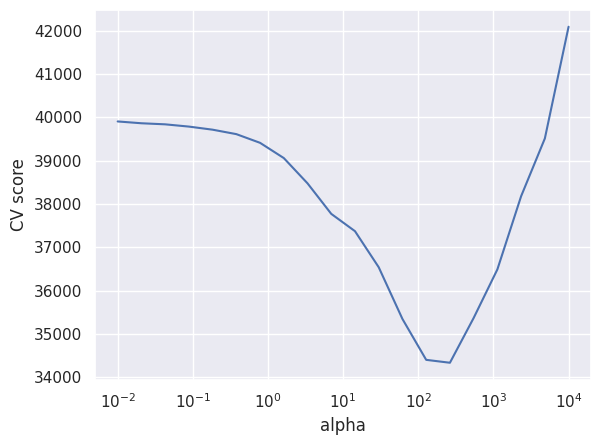

In [115]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [116]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 25643.4417


In [117]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 218


Иногда очень полезно посмотреть на распределение остатков. Нарисуем гистограмму распределения квадратичной ошибки на обучающих объектах:

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

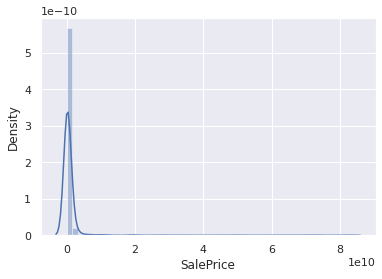

In [31]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)

Как видно из гистограммы, есть примеры с очень большими остатками. Попробуем их выбросить из обучающей выборки. Например, выбросим примеры, остаток у которых больше 0.95-квантили.

In [32]:
mask = (error < np.quantile(error, 0.95))

In [33]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 24963.5922


In [34]:
X_train = X_train[mask]
y_train = y_train[mask]

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

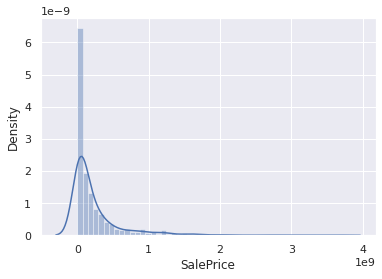

In [35]:
error = (y_train[mask] - model.predict(X_train[mask])) ** 2
sns.distplot(error)

Видим, что качество модели заметно улучшилось! Также бывает очень полезно посмотреть на примеры с большими остатками и попытаться понять, почему же модель на них так сильно ошибается: это может дать понимание, как модель можно улучшить.

P.S. Материал рассказа во многом взят из ноутбука, подготовленными [коллегами](https://github.com/esokolov).